In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib inline

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["font.size"] = 11

palette = ["#003f5c",
                     "#ffa600",
                     "#bc5090"]

from functools import partial, reduce
from itertools import product

import seaborn as sns


from analyze_data import result, get_summary

from create_figures import add_p_bars, boxplot, add_multilevel_xticks, lineplot

folder = '/media/raphael/PortableSSD/diploma_thesis/Data'

In [2]:
from matplotlib.ticker import AutoMinorLocator
def prettify(ax, *args,
             title = None,
             x = ("x-axis", ""),
             y = ("y-axis", ""),
             **kwargs):
    ax.set_title(title)
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel(x[0] if len(x[1])==0 else f"{x[0]} [{x[1]}]")
    ax.set_ylabel(y[0] if len(y[1])==0 else f"{y[0]} [{y[1]}]")
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which = "both", 
                   direction = "in")
    if ax.get_legend() != None:
        ax.get_legend().set_title("")
        ax.get_legend().set(alpha = 0, frame_on=False)
    return ax


# Nearest Neighbour


In [3]:
NN_df = pd.read_csv(f'{folder}/3. Plasmid moves cargo into Lysosomes/LC3_distances.csv').sort_values("Group", axis=0, ascending=False)
NN_df.head()


,d,CID,Group
9198,2.204689,453,X
9193,0.798684,453,X
9185,2.240615,453,X
9186,2.231738,453,X
9187,2.225376,453,X


In [4]:
def sample_cdf(x, fine = 0.01, range =(0,1)):
    r = np.arange(*range,fine)
    stacked_d = np.tile(x.values, (len(r),1))
    stacked_r = np.tile(r, (len(x),1)).T
    cdf = np.mean(
        np.less(stacked_d, stacked_r),
        axis = 1)
    return pd.Series(cdf, index=r)

cell_NN = NN_df.groupby("CID")["d"].apply(sample_cdf).reset_index().rename(columns={"level_1": "r"}).join(NN_df.groupby("CID")["Group"].first(), on = "CID", how = "left").sort_values(["Group","CID","r"], axis=0, ascending=[False,True,True])
cell_NN["diff"] = cell_NN.groupby("CID")[["d"]].transform(lambda x: np.diff(x,prepend = 0)/0.1)
# cell_NN = NN_df.groupby("CID")["d"].apply(sample_cdf).reset_index().rename(columns={"level_1": "r"})

print(cell_NN.shape)
cell_NN.head()


(7800, 5)


,CID,r,d,Group,diff
3300,404,0.00,0.000000,X,0.000000
3301,404,0.01,0.004831,X,0.048309
3302,404,0.02,0.004831,X,0.000000
3303,404,0.03,0.004831,X,0.000000
3304,404,0.04,0.004831,X,0.000000


In [9]:
from analyze_data import pv_to_star

def analyze(x, ctrl=None, n_iter = 100000):
    S = {}
    S["mean"] = np.mean(x*100)
    permut = np.mean(np.random.choice(x.values.T[0]*100, (len(x),n_iter)), axis = 0)
    print(permut)
    S["ci_lo"] = np.quantile(permut, 0.025)
    S["ci_hi"] = np.quantile(permut, 0.975)
    permut_ctrl = np.mean(np.random.choice(ctrl*100, (len(ctrl),n_iter)),axis = 0)
    S["p"] = np.mean(permut-permut_ctrl < 0)
    
    return pd.Series(S)

summary_df = NN_df.groupby(["Group","CID"])["d"].apply(lambda x: np.mean(x < 0.25)).reset_index().sort_values("Group", axis=0, ascending=False)
ctrl = summary_df.loc[summary_df["Group"]=="X","d"].values
summary = summary_df.groupby("Group")[["d"]].apply(partial(analyze, ctrl = ctrl))
summary["star"] = pv_to_star(summary["p"])
summary['n'] = summary_df.groupby("Group")[["d"]].count()
summary.round(4).head()


[28.68927409 29.57120663 28.49940545 ... 25.19826272 31.75444852
 27.67265983]
[15.17347883 14.96229153 17.55746536 ... 18.67832264 15.77455778
 13.91866753]
[6.19087566 8.17533515 7.27866442 ... 5.93802985 7.05760726 3.74163669]


,mean,ci_lo,ci_hi,p,star,n
Group,,,,,,
FY,27.0740,19.3553,34.3546,0.0000,****,14
TP,15.3502,10.8308,20.4104,0.0005,***,36
X,5.9005,2.9314,9.4938,0.4985,ns,28


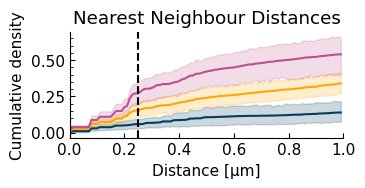

In [6]:
import matplotlib.transforms as transforms
import matplotlib.patches as patches



fig1, ax = plt.subplots(figsize=(3.54,3.54/2), layout = "constrained")
# ax.add_patch(patches.Rectangle(
#         (0, 0),   # (x,y)
#         0.25,          # width
#         1,          # height
#         alpha = 0.5,
#         transform = transforms.blended_transform_factory(
#     ax.transData, ax.transAxes))) #transparency
# ax = sns.histplot(cell_NN, x = "diff", hue = "Group", ax = ax, multiple = "dodge", binrange =(0,1), palette = palette,stat="probability", cumulative = True, common_norm = False)
ax = sns.lineplot(cell_NN,x="r", y = "d", hue = "Group", ax = ax, palette = palette)
# ax = sns.ecdfplot(NN_df, x = "d", hue = "Group", ax = ax, multiple = "dodge", binrange =(0,1), palette = palette)
ax.set_xlim(0,1)
ax.axvline(0.25, linestyle = "--", color = "k")
ax = prettify(ax,
              title = "Nearest Neighbour Distances",
              x = ("Distance","µm"),
              y = ("Cumulative density",""))
ax.get_legend().remove()

fig1.savefig("../../plots/Fig3_CDF.svg")


/tmp/ipykernel_15459/2074078092.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Ctrl","TP","FY"])


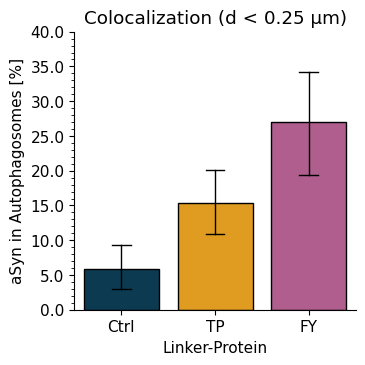

In [7]:
def formatter(x, pos):
        del pos
        return str(np.round(x*100, 3))

fig2,ax = plt.subplots(figsize = (3.54,3.54), layout = "constrained")
ax = sns.barplot(data = summary_df,
                x = "Group",
                y = "d",
                hue = "Group",
                legend = False,
                ax = ax,
                palette = ["#003f5c",
                     "#ffa600",
                     "#bc5090"],
                seed = 888,
                alpha = 1,
                capsize = 0.2,
                err_kws = {
                     "linewidth": 1,
                     "color":"0"
                })
ax = sns.barplot(data = summary_df,
                x = "Group",
                y = "d",
                ax = ax,
                color = "k",
                fill = False,
                linewidth = 1,
                errorbar = None)
ax = prettify(ax,
              title = "Colocalization (d < 0.25 µm)",
              x = ("Linker-Protein",""),
              y = ("aSyn in Autophagosomes","%"))
ax.set_xticklabels(["Ctrl","TP","FY"])
ax.yaxis.set_major_formatter(formatter)
ax.tick_params(axis = "x",direction = "out")
ax.tick_params(axis = "y",which="both",direction = "out")
ax.set_ylim(0,0.4)
fig2.tight_layout
fig2.savefig("../../plots/Fig3_coloc.svg", format = "svg")


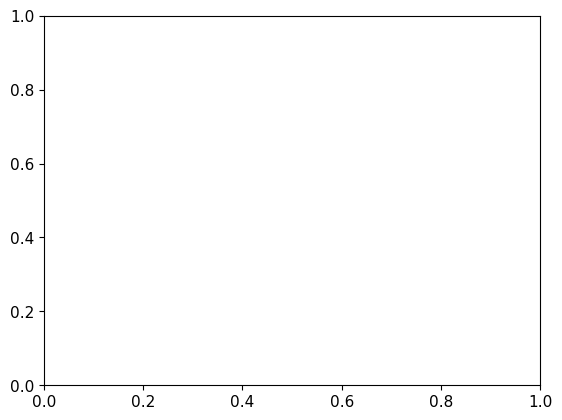

In [8]:
fig2, ax = plt.subplots()
